In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

# From here: https://www.kaggle.com/robertoruiz/sberbank-russian-housing-market/dealing-with-multicollinearity/notebook
macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]


data_train  = pd.read_csv('train-5.csv', parse_dates=['timestamp'])
data_test = pd.read_csv('test-5.csv', parse_dates=['timestamp'])
data_macro = pd.read_csv("macro.csv", parse_dates=['timestamp'], usecols=['timestamp'] + macro_cols)



In [62]:
# Changing some unreasonable numeric features to object features
#data_train['material'] = data_train['material'].astype('object')
#data_train['state'] = data_train['state'].astype('object')

In [63]:
# remove some outlier data in price_doc
ulimit = np.percentile(data_train.price_doc.values, 99)
llimit = np.percentile(data_train.price_doc.values, 1)
#data_train.loc[data_train['price_doc'] >ulimit, 'price_doc'] = ulimit
#data_train.loc[data_train['price_doc'] <llimit, 'price_doc'] = llimit

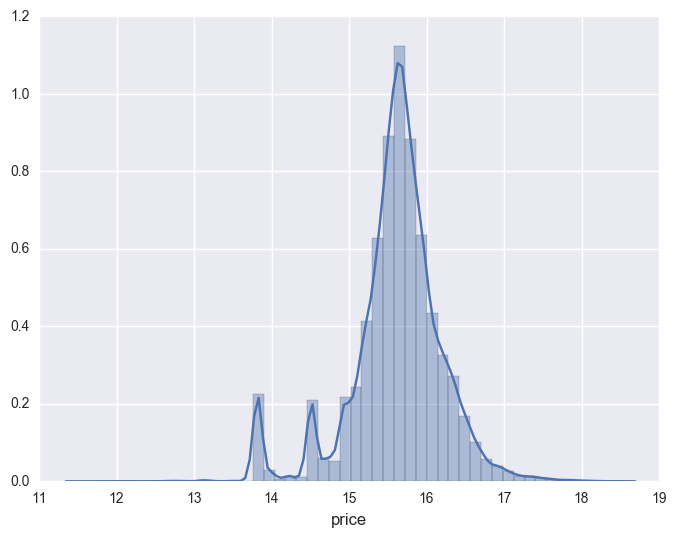

In [64]:
plt.figure(figsize=(8, 6))
sns.distplot(a=np.log1p(data_train['price_doc']), bins=50, kde=True)
plt.xlabel("price", fontsize=12)
plt.show()

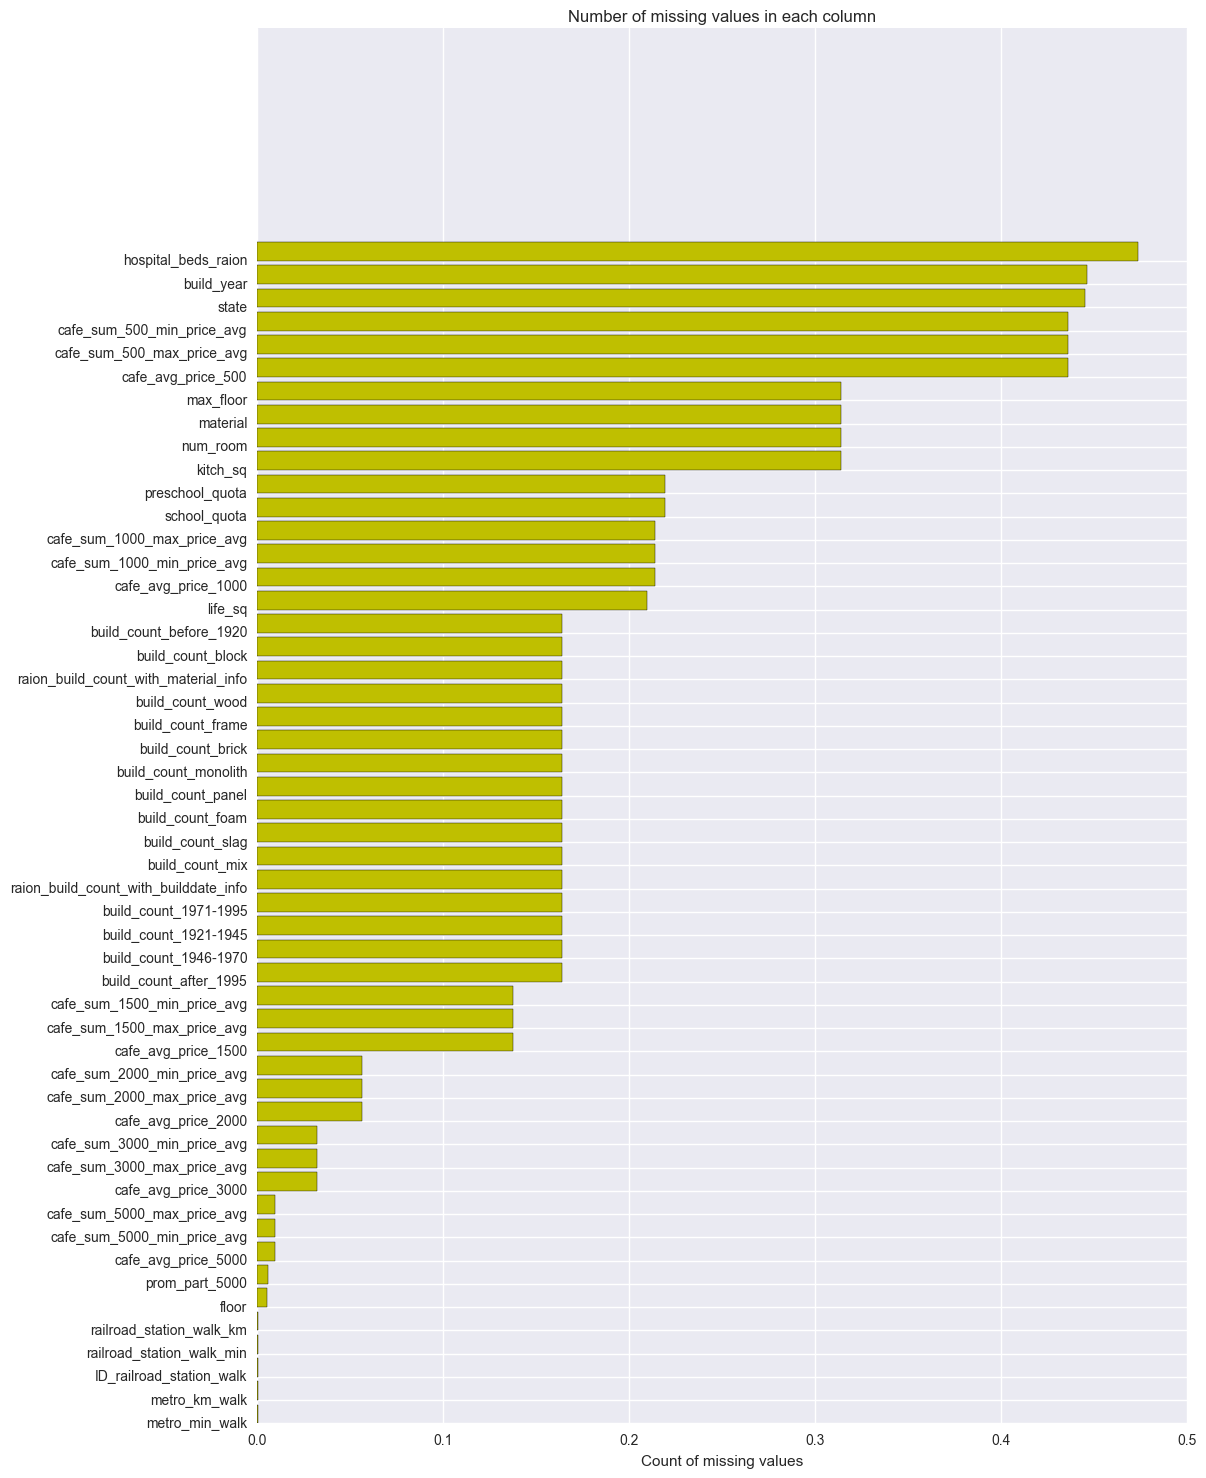

In [65]:
missing_df = (data_train.isnull().sum(axis=0)/data_train.shape[0]).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values('missing_count', axis=0,  ascending=True)
width = 0.8
ind = np.arange(missing_df.shape[0])
fig, ax = plt.subplots(figsize=(12, 18))
ax.barh(ind, missing_df['missing_count'], color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df['column_name'], rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()



In [67]:
# Dropping the column which has more than half missing data
drop_columns = missing_df.ix[missing_df['missing_count']>0.5, 'column_name'].values
data_train.drop(drop_columns, axis=1, inplace=True)
data_test.drop(drop_columns, axis=1, inplace=True)


price_doc: 	1.0
num_room: 	0.476336538006
full_sq: 	0.341840459754
sport_count_5000: 	0.294864146805
sport_count_3000: 	0.290650591789
trc_count_5000: 	0.28937091093
zd_vokzaly_avto_km: 	-0.284068558845
sadovoe_km: 	-0.283621518664
kremlin_km: 	-0.279249338572
bulvar_ring_km: 	-0.279158266682
sport_count_2000: 	0.278055663847
ttk_km: 	-0.272619817074
office_sqm_5000: 	0.269976775898
trc_sqm_5000: 	0.268071919626
sport_count_1500: 	0.258376349159
nuclear_reactor_km: 	-0.257945674427
sport_objects_raion: 	0.252794428742
trc_count_3000: 	0.242068330745
cafe_count_5000_price_1000: 	0.240464431592
stadium_km: 	-0.236924097457


ValueError: need more than 1 value to unpack

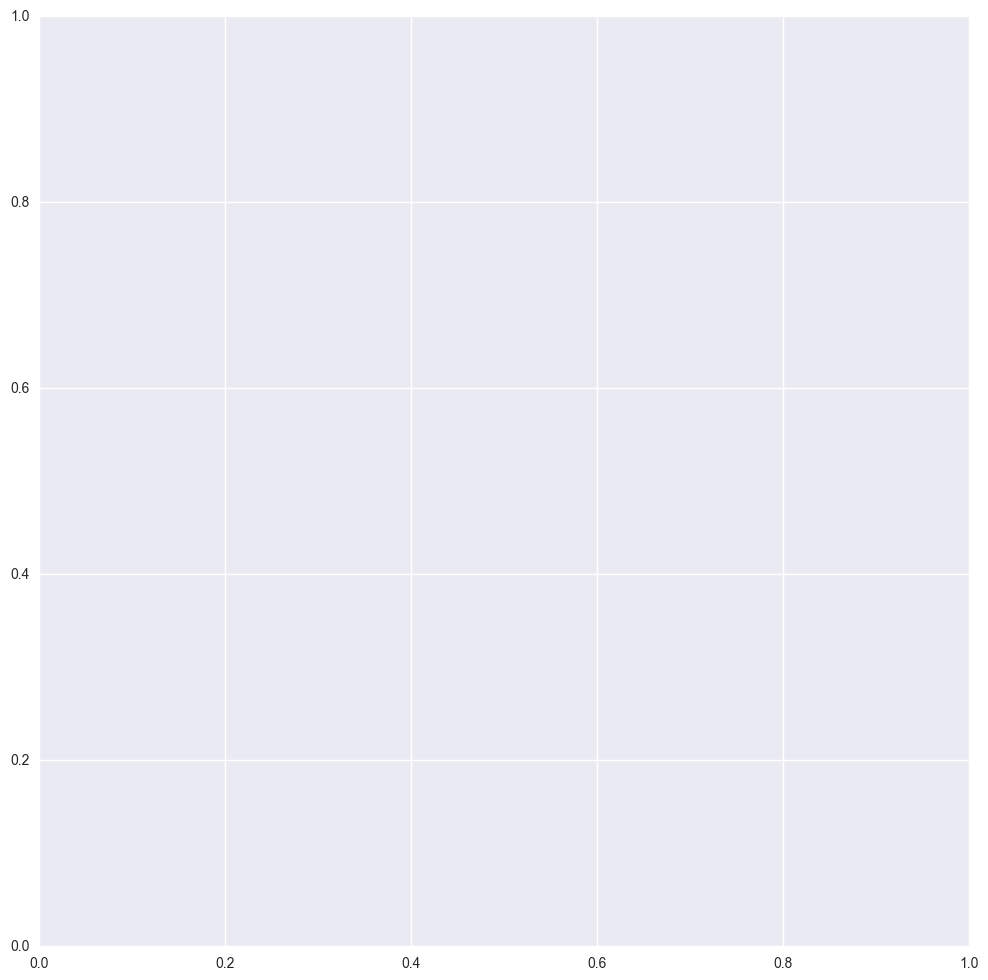

In [71]:
'''
cor = data_train.select_dtypes(exclude = ['object']).iloc[:,1:].corr()
cor_top20 = cor['price_doc'].sort_values(ascending=False).head()
cor_dict = cor['price_doc'].to_dict()
i = 0 
#corr_top20
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    if(i==20):
        break
    print("{0}: \t{1}".format(*ele))
    i+=1

plt.figure(figsize=(12,12))
sns.heatmap(cor_top20, vmax=1, square=True)
'''

In [36]:
train_y = np.log1p(data_train.price_doc.values)
test_id = data_test['id']
data_train = data_train.drop(["id", "price_doc"], axis=1)
data_test= data_test.drop(["id"], axis=1)
data_all = pd.concat([data_train, data_test], ignore_index=True)
data_all = pd.merge(data_all, data_macro, on='timestamp', how='left')
#data_all = pd.merge(data_all, on='timestamp', how='left')


In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer

from statsmodels.stats.outliers_influence import variance_inflation_factor

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            # Loop repeatedly until we find that all columns within our dataset
            # have a VIF value we're happy with.
            variables = X.columns
            dropped=False
            vif = []
            new_vif = 0
            for var in X.columns:
                new_vif = variance_inflation_factor(X[variables].values, X.columns.get_loc(var))
                vif.append(new_vif)
                if np.isinf(new_vif):
                    break
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                #print 'Dropping {X.columns[{0}]} with vif={{1}}'.format(maxloc, max_vif)
                print X.columns[maxloc]
                print max_vif
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [38]:
# This section added:  drop crazy data points
data_all.drop(data_train[data_train["life_sq"] > 7000].index, inplace=True)
data_all.drop(data_train[data_train["full_sq"] > 5000].index, inplace=True)

#drop strange years
#ind = train_df[(train_df['build_year'] <= 1691) | (train_df['build_year'] >= 2018)].index




# Add month 
data_all['month'] = data_all.timestamp.dt.month


# Other feature engineering
data_all['rel_floor'] = data_all['floor'] / data_all['max_floor'].astype(float)
data_all['rel_kitch_sq'] = data_all['kitch_sq'] / data_all['full_sq'].astype(float)


# week of year #
data_all["week_of_year"] = data_all["timestamp"].dt.weekofyear


# day of week #
data_all["day_of_week"] = data_all["timestamp"].dt.weekday

# floor of the house
data_all['floor_25'] = (data_all['floor']>25.0)*1

# yearmonth
#data_all['yearmonth'] = pd.to_datetime(data_all['timestamp'])
#data_all['yearmonth'] = data_all['yearmonth'].dt.year*100 + data_all['yearmonth'].dt.month
#data_all_groupby = data_all.groupby('yearmonth')



'''
# ratio of living area to full area #
train_df["ratio_life_sq_full_sq"] = train_df["life_sq"] / np.maximum(train_df["full_sq"].astype("float"),1)
train_df["ratio_life_sq_full_sq"].ix[train_df["ratio_life_sq_full_sq"]<0] = 0
train_df["ratio_life_sq_full_sq"].ix[train_df["ratio_life_sq_full_sq"]>1] = 1

# ratio of kitchen area to living area #
train_df["ratio_kitch_sq_life_sq"] = train_df["kitch_sq"] / np.maximum(train_df["life_sq"].astype("float"),1)
train_df["ratio_kitch_sq_life_sq"].ix[train_df["ratio_kitch_sq_life_sq"]<0] = 0
train_df["ratio_kitch_sq_life_sq"].ix[train_df["ratio_kitch_sq_life_sq"]>1] = 1

# ratio of kitchen area to full area #
train_df["ratio_kitch_sq_full_sq"] = train_df["kitch_sq"] / np.maximum(train_df["full_sq"].astype("float"),1)
train_df["ratio_kitch_sq_full_sq"].ix[train_df["ratio_kitch_sq_full_sq"]<0] = 0
train_df["ratio_kitch_sq_full_sq"].ix[train_df["ratio_kitch_sq_full_sq"]>1] = 1
'''




'\n# ratio of living area to full area #\ntrain_df["ratio_life_sq_full_sq"] = train_df["life_sq"] / np.maximum(train_df["full_sq"].astype("float"),1)\ntrain_df["ratio_life_sq_full_sq"].ix[train_df["ratio_life_sq_full_sq"]<0] = 0\ntrain_df["ratio_life_sq_full_sq"].ix[train_df["ratio_life_sq_full_sq"]>1] = 1\n\n# ratio of kitchen area to living area #\ntrain_df["ratio_kitch_sq_life_sq"] = train_df["kitch_sq"] / np.maximum(train_df["life_sq"].astype("float"),1)\ntrain_df["ratio_kitch_sq_life_sq"].ix[train_df["ratio_kitch_sq_life_sq"]<0] = 0\ntrain_df["ratio_kitch_sq_life_sq"].ix[train_df["ratio_kitch_sq_life_sq"]>1] = 1\n\n# ratio of kitchen area to full area #\ntrain_df["ratio_kitch_sq_full_sq"] = train_df["kitch_sq"] / np.maximum(train_df["full_sq"].astype("float"),1)\ntrain_df["ratio_kitch_sq_full_sq"].ix[train_df["ratio_kitch_sq_full_sq"]<0] = 0\ntrain_df["ratio_kitch_sq_full_sq"].ix[train_df["ratio_kitch_sq_full_sq"]>1] = 1\n'

In [39]:
'''
for num in number_columns:
    if(sum(data_all[num].isnull())>0):
        isnull_raw = data_all[num].isnull()
        isnull_yearmonth = data_all.ix[isnull_raw, 'yearmonth'].values
        data_all_groupby[num].transform(lambda x: x.fillna(x.mean()))
        #data_all.loc[isnull_raw, num] = [num].mean()
        #data_all[num].fillna(data_all[num].mean())
    #data_test[num].fillna(data_test[num].mean(axis=0))

#price_median = data_train.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()
#plt.figure(figsize=(6, 6))
#sns.barplot(x='yearmonth', y='price_doc', data=price_median)
#plt.xticks(rotation='vertical')
#plt.show()
'''


"\nfor num in number_columns:\n    if(sum(data_all[num].isnull())>0):\n        isnull_raw = data_all[num].isnull()\n        isnull_yearmonth = data_all.ix[isnull_raw, 'yearmonth'].values\n        data_all_groupby[num].transform(lambda x: x.fillna(x.mean()))\n        #data_all.loc[isnull_raw, num] = [num].mean()\n        #data_all[num].fillna(data_all[num].mean())\n    #data_test[num].fillna(data_test[num].mean(axis=0))\n\n#price_median = data_train.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()\n#plt.figure(figsize=(6, 6))\n#sns.barplot(x='yearmonth', y='price_doc', data=price_median)\n#plt.xticks(rotation='vertical')\n#plt.show()\n"

In [40]:
# Remove timestamp column (may overfit the model in train)
data_all.drop(['timestamp'], axis=1, inplace=True)
object_columns =  data_all.columns[data_all.dtypes == 'object']
number_columns = data_all.columns[data_all.dtypes != 'object']



In [41]:
from sklearn import model_selection, preprocessing

    #data_all[ob].fillna(data_all[ob].value_counts().index[0])
    #dummies = pd.get_dummies(data=data_all[ob], prefix="{}#".format(ob))
    #data_all.drop(ob, axis=1, inplace=True)
    #data_all = data_all.join(dummies)
data_train = data_all.iloc[:data_train.shape[0],:]
data_test = data_all.iloc[data_train.shape[0]:data_all.shape[0],:]



In [42]:
'''
train_df = data_train
test_df = data_test
kitch_ratio = train_df['full_sq']/train_df['kitch_sq']
train_df['kitch_sq']=train_df['kitch_sq'].fillna(train_df['full_sq'] /kitch_ratio.median())
test_df['kitch_sq']=test_df['kitch_sq'].fillna(test_df['full_sq'] /kitch_ratio.median())

lifesq_ratio = train_df['full_sq']/train_df['life_sq']
train_df['life_sq']=train_df['life_sq'].fillna(train_df['full_sq'] /lifesq_ratio.median())
test_df['life_sq']=test_df['life_sq'].fillna(test_df['full_sq'] /lifesq_ratio.median())

train_df=train_df.fillna(train_df.median(),inplace=True)
test_df=test_df.fillna(test_df.median(),inplace=True)

data_train = train_df
data_test = test_df 
'''

"\ntrain_df = data_train\ntest_df = data_test\nkitch_ratio = train_df['full_sq']/train_df['kitch_sq']\ntrain_df['kitch_sq']=train_df['kitch_sq'].fillna(train_df['full_sq'] /kitch_ratio.median())\ntest_df['kitch_sq']=test_df['kitch_sq'].fillna(test_df['full_sq'] /kitch_ratio.median())\n\nlifesq_ratio = train_df['full_sq']/train_df['life_sq']\ntrain_df['life_sq']=train_df['life_sq'].fillna(train_df['full_sq'] /lifesq_ratio.median())\ntest_df['life_sq']=test_df['life_sq'].fillna(test_df['full_sq'] /lifesq_ratio.median())\n\ntrain_df=train_df.fillna(train_df.median(),inplace=True)\ntest_df=test_df.fillna(test_df.median(),inplace=True)\n\ndata_train = train_df\ndata_test = test_df \n"

In [43]:
for ob in object_columns:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(data_train[ob].values))
    data_train[ob] = lbl.fit_transform(list(data_train[ob].values))
    
for ob in object_columns:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(data_test[ob].values))
    data_test[ob] = lbl.fit_transform(list(data_test[ob].values))
    


/Users/adslwang4601/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/adslwang4601/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [44]:
for num in number_columns:
    data_train[num] = data_train[num].fillna(data_train[num].median())
    data_test[num] = data_test[num].fillna(data_test[num].median())
    
for col in object_columns:
    data_train[col] = data_train[col].fillna(data_train[col].median())
    data_test[col] = data_test[col].fillna(data_test[col].median())

    #data_all[num] = data_all[num].fillna(data_all[num].value_counts()[0])
    #data_test[num].fillna(data_test[num].mean(axis=0))

/Users/adslwang4601/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/adslwang4601/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/adslwang4601/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [45]:
'''
transformer = ReduceVIF()
X = data_all
# Only use 10 columns for speed in this example
data_all = transformer.fit_transform(data_train[data_train.columns[0:50]], train_y)

data_all.head()
'''


'\ntransformer = ReduceVIF()\nX = data_all\n# Only use 10 columns for speed in this example\ndata_all = transformer.fit_transform(data_train[data_train.columns[0:50]], train_y)\n\ndata_all.head()\n'

In [46]:
'''
from sklearn.decomposition import PCA
components = 20
model = PCA(n_components=components)
model.fit(data_train)
ex_variance = pd.DataFrame({'ex_variance':model.explained_variance_ratio_ [0:components], 'n_component':range(1,components+1)})
ax = sns.barplot(x='n_component', y='ex_variance', data=ex_variance)
ax.set_title('PCA_variance_explained')
plt.show()
'''

"\nfrom sklearn.decomposition import PCA\ncomponents = 20\nmodel = PCA(n_components=components)\nmodel.fit(data_train)\nex_variance = pd.DataFrame({'ex_variance':model.explained_variance_ratio_ [0:components], 'n_component':range(1,components+1)})\nax = sns.barplot(x='n_component', y='ex_variance', data=ex_variance)\nax.set_title('PCA_variance_explained')\nplt.show()\n"

In [47]:
#data_train = model.fit_transform(data_train)
#data_test = model.fit_transform(data_test)


In [48]:
# Stacking Starter based on Allstate Faron's Script
#https://www.kaggle.com/mmueller/allstate-claims-severity/stacking-starter/run/390867
# Preprocessing from Alexandru Papiu
#https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
'''
SEED = 1
NFOLDS = 3
import pandas as pd
import numpy as np
from scipy.stats import skew
import xgboost as xgb
from sklearn.cross_validation import KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, Lasso
from math import sqrt

ntrain = data_train.shape[0]
ntest = data_test.shape[0]
print ntrain
print ntest

x_train = np.array(data_train)
x_test = np.array(data_test)
y_train = train_y
kf = KFold(ntrain, n_folds=3, shuffle=True, random_state=SEED)
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))

def get_oof(clf):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)


et_params = {
    'n_jobs': 16,
    'n_estimators': 100,
    'max_features': 0.5,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

rf_params = {
    'n_jobs': 16,
    'n_estimators': 100,
    'max_features': 0.2,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'reg:linear',
    'max_depth': 4,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'rmse',
    'nrounds': 500
}



rd_params={
    'alpha': 10
}


ls_params={
    'alpha': 0.005
}



xg = XgbWrapper(seed=SEED, params=xgb_params)
et = SklearnWrapper(clf=ExtraTreesRegressor, seed=SEED, params=et_params)
rf = SklearnWrapper(clf=RandomForestRegressor, seed=SEED, params=rf_params)
rd = SklearnWrapper(clf=Ridge, seed=SEED, params=rd_params)
ls = SklearnWrapper(clf=Lasso, seed=SEED, params=ls_params)



xg_oof_train, xg_oof_test = get_oof(xg)
et_oof_train, et_oof_test = get_oof(et)
rf_oof_train, rf_oof_test = get_oof(rf)
rd_oof_train, rd_oof_test = get_oof(rd)
ls_oof_train, ls_oof_test = get_oof(ls)

print("XG-CV: {}".format(sqrt(mean_squared_error(y_train, xg_oof_train))))
print("ET-CV: {}".format(sqrt(mean_squared_error(y_train, et_oof_train))))
print("RF-CV: {}".format(sqrt(mean_squared_error(y_train, rf_oof_train))))
print("RD-CV: {}".format(sqrt(mean_squared_error(y_train, rd_oof_train))))
print("LS-CV: {}".format(sqrt(mean_squared_error(y_train, ls_oof_train))))

x_train = np.concatenate((xg_oof_train, et_oof_train, rf_oof_train, rd_oof_train, ls_oof_train), axis=1)
x_test = np.concatenate((xg_oof_test, et_oof_test, rf_oof_test, rd_oof_test, ls_oof_test), axis=1)

print("{},{}".format(x_train.shape, x_test.shape))


dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test)
      


xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.8,
    'silent': 1,
    'subsample': 0.6,
    'learning_rate': 0.01,
    'objective': 'reg:linear',
    'max_depth': 1,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'rmse'}

'''

'\nSEED = 1\nNFOLDS = 3\nimport pandas as pd\nimport numpy as np\nfrom scipy.stats import skew\nimport xgboost as xgb\nfrom sklearn.cross_validation import KFold\nfrom sklearn.ensemble import ExtraTreesRegressor\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import mean_squared_error\nfrom sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, Lasso\nfrom math import sqrt\n\nntrain = data_train.shape[0]\nntest = data_test.shape[0]\nprint ntrain\nprint ntest\n\nx_train = np.array(data_train)\nx_test = np.array(data_test)\ny_train = train_y\nkf = KFold(ntrain, n_folds=3, shuffle=True, random_state=SEED)\nclass SklearnWrapper(object):\n    def __init__(self, clf, seed=0, params=None):\n        params[\'random_state\'] = seed\n        self.clf = clf(**params)\n\n    def train(self, x_train, y_train):\n        self.clf.fit(x_train, y_train)\n\n    def predict(self, x):\n        return self.clf.predict(x)\n\nclass XgbWrapper(object):\n    def __init__(sel

In [49]:

res = xgb.cv(xgb_params, dtrain, num_boost_round=1000, nfold=4, seed=SEED, stratified=False,
             early_stopping_rounds=25, verbose_eval=10, show_stdv=True)

best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]

print('Ensemble-CV: {0}+{1}'.format(cv_mean, cv_std))


"\nres = xgb.cv(xgb_params, dtrain, num_boost_round=1000, nfold=4, seed=SEED, stratified=False,\n             early_stopping_rounds=25, verbose_eval=10, show_stdv=True)\n\nbest_nrounds = res.shape[0] - 1\ncv_mean = res.iloc[-1, 0]\ncv_std = res.iloc[-1, 1]\n\nprint('Ensemble-CV: {0}+{1}'.format(cv_mean, cv_std))\n"

In [50]:
import xgboost as xgb
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.grid_search import GridSearchCV
train_X = data_train
test_X = data_test
dtrain = xgb.DMatrix(train_X, train_y)
xgb_params={ 'eta': 0.05,
             'max_depth': 5,
             'subsample': 0.7,
             'colsample_bytree': 0.7,
             'objective': 'reg:linear',
             'eval_metric': 'rmse',
             'silent': 1
}

cv_output  = xgb.cv(dict(xgb_params, silent=0), dtrain, num_boost_round=1000, early_stopping_rounds=20, verbose_eval=20)
             
cv_output



[0]	train-rmse:14.3667+0.0019313	test-rmse:14.3667+0.00422203
[20]	train-rmse:5.18113+0.000436621	test-rmse:5.18113+0.0044175
[40]	train-rmse:1.93771+0.000814179	test-rmse:1.93915+0.00313509
[60]	train-rmse:0.881067+0.00240551	test-rmse:0.888567+0.00359826
[80]	train-rmse:0.621469+0.00298042	test-rmse:0.637425+0.00668675
[100]	train-rmse:0.57459+0.0032475	test-rmse:0.597543+0.00798896
[120]	train-rmse:0.563813+0.00344199	test-rmse:0.592287+0.00832295
[140]	train-rmse:0.558411+0.00322064	test-rmse:0.591772+0.0084035


,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
0,14.366708,0.004222,14.366708,0.001931
1,13.649623,0.004323,13.649624,0.001805
2,12.968642,0.004351,12.968643,0.001755
3,12.321720,0.004563,12.321720,0.001518
4,11.707011,0.004569,11.707012,0.001492
5,11.123361,0.004621,11.123361,0.001423
6,10.568898,0.004701,10.568898,0.001301
7,10.042111,0.004713,10.042112,0.001251
8,9.541790,0.004850,9.541791,0.001094
9,9.066699,0.004918,9.066700,0.000991


In [430]:
num_boost_round = len(cv_output)
num_boost_round

133

In [238]:
num_boost_round = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=320)
num_boost_round = model.best_iteration
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_round)
preds = np.exp(model.predict(xgb.DMatrix(test_X, feature_names=test_X.columns.values)))-1
submission = pd.DataFrame()
submission['id'] = test_id
submission["price_doc"]= preds

submission.to_csv("sub.csv",index=False)

In [239]:
num_boost_round

319

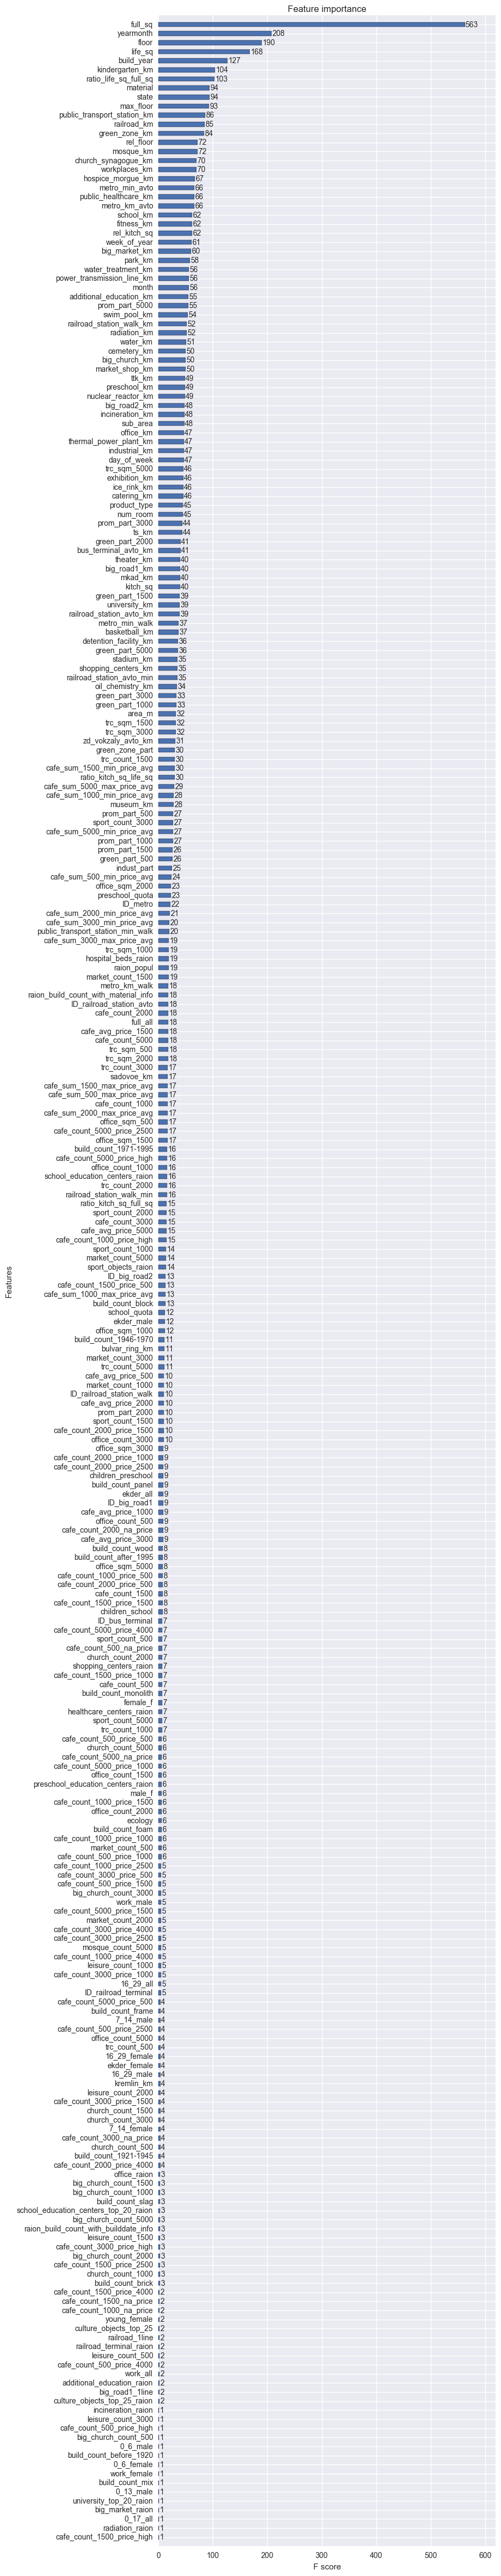

In [147]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(8, 60))
xgb.plot_importance(model, height=0.5, ax=ax)
#model = xgb.train(xgb_params, dtrain, num_boost_round=400, early_stopping_rounds=50)


In [119]:
preds.shape

(7662,)

In [120]:
import operator 
importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))  
  
df_importance = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_importance


,feature,fscore
0,big_road1_1line,1
1,culture_objects_top_25_raion,1
2,big_church_count_5000,1
3,0_6_female,1
4,0_17_all,1
5,big_market_raion,1
6,university_top_20_raion,1
7,7_14_all,1
8,big_church_count_500,1
9,0_13_male,1


In [121]:
features_importance = df_importance.index[:100];
train_X = data_train.ix[:,features_importance]
test_X = data_test.ix[:,features_importance]
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
xgb_params={  
                        'learning_rate':0.05,
                         'max_depth' : 5,
                         'min_child_weight' : 7,
                         'gamma':0.0,
                         'n_estimators':1000,
                         'subsample':0.7,
                         'colsample_bytree':0.7,
                         'scale_pos_weight':1,
                         'seed':27
}
#model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)



In [ ]:
xgb.cv(dict(xgb_params, silent=0), dtrain, num_boost_round=1000, early_stopping_rounds=20, verbose_eval=20)


[0]	train-rmse:14.3667+0.00176651	test-rmse:14.3667+0.00364645
[20]	train-rmse:5.1745+0.000345092	test-rmse:5.17483+0.00311766
[40]	train-rmse:1.91028+0.000446353	test-rmse:1.91162+0.00238264
[60]	train-rmse:0.811555+0.0015584	test-rmse:0.817775+0.00134302


KeyboardInterrupt: 

In [301]:
preds = model.predict(xgb.DMatrix(test_X, feature_names=test_X.columns.values))
submission = pd.DataFrame()
submission['id'] = test_id
submission["price_doc"]= preds

submission.to_csv("sub.csv",index=False)


ValueError: feature_names mismatch: ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'kitch_sq', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'children_preschool', 'preschool_quota', 'preschool_education_centers_raion', 'children_school', 'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 'hospital_beds_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'sport_objects_raion', 'additional_education_raion', 'culture_objects_top_25_raion', 'shopping_centers_raion', 'office_raion', 'full_all', 'male_f', 'female_f', 'young_all', 'young_male', 'young_female', 'work_all', 'work_male', 'work_female', 'ekder_all', 'ekder_male', 'ekder_female', '0_6_all', '0_6_male', '0_6_female', '7_14_all', '7_14_male', '7_14_female', '0_17_all', '0_17_male', '0_17_female', '16_29_all', '16_29_male', '16_29_female', '0_13_all', '0_13_male', '0_13_female', 'raion_build_count_with_material_info', 'build_count_block', 'build_count_wood', 'build_count_frame', 'build_count_brick', 'build_count_monolith', 'build_count_panel', 'build_count_foam', 'build_count_slag', 'build_count_mix', 'raion_build_count_with_builddate_info', 'build_count_before_1920', 'build_count_1921-1945', 'build_count_1946-1970', 'build_count_1971-1995', 'build_count_after_1995', 'ID_metro', 'metro_min_avto', 'metro_km_avto', 'metro_min_walk', 'metro_km_walk', 'kindergarten_km', 'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_treatment_km', 'cemetery_km', 'incineration_km', 'railroad_station_walk_km', 'railroad_station_walk_min', 'ID_railroad_station_walk', 'railroad_station_avto_km', 'railroad_station_avto_min', 'ID_railroad_station_avto', 'public_transport_station_km', 'public_transport_station_min_walk', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km', 'big_road1_km', 'ID_big_road1', 'big_road2_km', 'ID_big_road2', 'railroad_km', 'zd_vokzaly_avto_km', 'ID_railroad_terminal', 'bus_terminal_avto_km', 'ID_bus_terminal', 'oil_chemistry_km', 'nuclear_reactor_km', 'radiation_km', 'power_transmission_line_km', 'thermal_power_plant_km', 'ts_km', 'big_market_km', 'market_shop_km', 'fitness_km', 'swim_pool_km', 'ice_rink_km', 'stadium_km', 'basketball_km', 'hospice_morgue_km', 'detention_facility_km', 'public_healthcare_km', 'university_km', 'workplaces_km', 'shopping_centers_km', 'office_km', 'additional_education_km', 'preschool_km', 'big_church_km', 'church_synagogue_km', 'mosque_km', 'theater_km', 'museum_km', 'exhibition_km', 'catering_km', 'green_part_500', 'prom_part_500', 'office_count_500', 'office_sqm_500', 'trc_count_500', 'trc_sqm_500', 'cafe_count_500', 'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg', 'cafe_avg_price_500', 'cafe_count_500_na_price', 'cafe_count_500_price_500', 'cafe_count_500_price_1000', 'cafe_count_500_price_1500', 'cafe_count_500_price_2500', 'cafe_count_500_price_4000', 'cafe_count_500_price_high', 'big_church_count_500', 'church_count_500', 'mosque_count_500', 'leisure_count_500', 'sport_count_500', 'market_count_500', 'green_part_1000', 'prom_part_1000', 'office_count_1000', 'office_sqm_1000', 'trc_count_1000', 'trc_sqm_1000', 'cafe_count_1000', 'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000', 'cafe_count_1000_na_price', 'cafe_count_1000_price_500', 'cafe_count_1000_price_1000', 'cafe_count_1000_price_1500', 'cafe_count_1000_price_2500', 'cafe_count_1000_price_4000', 'cafe_count_1000_price_high', 'big_church_count_1000', 'church_count_1000', 'mosque_count_1000', 'leisure_count_1000', 'sport_count_1000', 'market_count_1000', 'green_part_1500', 'prom_part_1500', 'office_count_1500', 'office_sqm_1500', 'trc_count_1500', 'trc_sqm_1500', 'cafe_count_1500', 'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 'cafe_avg_price_1500', 'cafe_count_1500_na_price', 'cafe_count_1500_price_500', 'cafe_count_1500_price_1000', 'cafe_count_1500_price_1500', 'cafe_count_1500_price_2500', 'cafe_count_1500_price_4000', 'cafe_count_1500_price_high', 'big_church_count_1500', 'church_count_1500', 'mosque_count_1500', 'leisure_count_1500', 'sport_count_1500', 'market_count_1500', 'green_part_2000', 'prom_part_2000', 'office_count_2000', 'office_sqm_2000', 'trc_count_2000', 'trc_sqm_2000', 'cafe_count_2000', 'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000', 'cafe_count_2000_na_price', 'cafe_count_2000_price_500', 'cafe_count_2000_price_1000', 'cafe_count_2000_price_1500', 'cafe_count_2000_price_2500', 'cafe_count_2000_price_4000', 'cafe_count_2000_price_high', 'big_church_count_2000', 'church_count_2000', 'mosque_count_2000', 'leisure_count_2000', 'sport_count_2000', 'market_count_2000', 'green_part_3000', 'prom_part_3000', 'office_count_3000', 'office_sqm_3000', 'trc_count_3000', 'trc_sqm_3000', 'cafe_count_3000', 'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg', 'cafe_avg_price_3000', 'cafe_count_3000_na_price', 'cafe_count_3000_price_500', 'cafe_count_3000_price_1000', 'cafe_count_3000_price_1500', 'cafe_count_3000_price_2500', 'cafe_count_3000_price_4000', 'cafe_count_3000_price_high', 'big_church_count_3000', 'church_count_3000', 'mosque_count_3000', 'leisure_count_3000', 'sport_count_3000', 'market_count_3000', 'green_part_5000', 'prom_part_5000', 'office_count_5000', 'office_sqm_5000', 'trc_count_5000', 'trc_sqm_5000', 'cafe_count_5000', 'cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000', 'cafe_count_5000_na_price', 'cafe_count_5000_price_500', 'cafe_count_5000_price_1000', 'cafe_count_5000_price_1500', 'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000', 'cafe_count_5000_price_high', 'big_church_count_5000', 'church_count_5000', 'mosque_count_5000', 'leisure_count_5000', 'sport_count_5000', 'market_count_5000', 'yearmonth', 'month', 'dow', 'material#_1.0', 'material#_2.0', 'material#_3.0', 'material#_4.0', 'material#_5.0', 'material#_6.0', 'state#_1.0', 'state#_2.0', 'state#_3.0', 'state#_4.0', 'state#_33.0', 'product_type#_Investment', 'product_type#_OwnerOccupier', 'sub_area#_Ajeroport', 'sub_area#_Akademicheskoe', 'sub_area#_Alekseevskoe', "sub_area#_Altuf'evskoe", 'sub_area#_Arbat', 'sub_area#_Babushkinskoe', 'sub_area#_Basmannoe', 'sub_area#_Begovoe', 'sub_area#_Beskudnikovskoe', 'sub_area#_Bibirevo', 'sub_area#_Birjulevo Vostochnoe', 'sub_area#_Birjulevo Zapadnoe', 'sub_area#_Bogorodskoe', 'sub_area#_Brateevo', 'sub_area#_Butyrskoe', 'sub_area#_Caricyno', 'sub_area#_Cheremushki', "sub_area#_Chertanovo Central'noe", 'sub_area#_Chertanovo Juzhnoe', 'sub_area#_Chertanovo Severnoe', 'sub_area#_Danilovskoe', 'sub_area#_Dmitrovskoe', 'sub_area#_Donskoe', 'sub_area#_Dorogomilovo', 'sub_area#_Filevskij Park', 'sub_area#_Fili Davydkovo', 'sub_area#_Gagarinskoe', "sub_area#_Gol'janovo", 'sub_area#_Golovinskoe', 'sub_area#_Hamovniki', 'sub_area#_Horoshevo-Mnevniki', 'sub_area#_Horoshevskoe', 'sub_area#_Hovrino', 'sub_area#_Ivanovskoe', 'sub_area#_Izmajlovo', 'sub_area#_Jakimanka', 'sub_area#_Jaroslavskoe', 'sub_area#_Jasenevo', 'sub_area#_Juzhnoe Butovo', 'sub_area#_Juzhnoe Medvedkovo', 'sub_area#_Juzhnoe Tushino', 'sub_area#_Juzhnoportovoe', 'sub_area#_Kapotnja', "sub_area#_Kon'kovo", 'sub_area#_Koptevo', 'sub_area#_Kosino-Uhtomskoe', 'sub_area#_Kotlovka', "sub_area#_Krasnosel'skoe", 'sub_area#_Krjukovo', 'sub_area#_Krylatskoe', 'sub_area#_Kuncevo', 'sub_area#_Kurkino', "sub_area#_Kuz'minki", 'sub_area#_Lefortovo', 'sub_area#_Levoberezhnoe', 'sub_area#_Lianozovo', 'sub_area#_Ljublino', 'sub_area#_Lomonosovskoe', 'sub_area#_Losinoostrovskoe', "sub_area#_Mar'ina Roshha", "sub_area#_Mar'ino", 'sub_area#_Marfino', 'sub_area#_Matushkino', 'sub_area#_Meshhanskoe', 'sub_area#_Metrogorodok', 'sub_area#_Mitino', 'sub_area#_Molzhaninovskoe', "sub_area#_Moskvorech'e-Saburovo", 'sub_area#_Mozhajskoe', 'sub_area#_Nagatino-Sadovniki', 'sub_area#_Nagatinskij Zaton', 'sub_area#_Nagornoe', 'sub_area#_Nekrasovka', 'sub_area#_Nizhegorodskoe', 'sub_area#_Novo-Peredelkino', 'sub_area#_Novogireevo', 'sub_area#_Novokosino', 'sub_area#_Obruchevskoe', 'sub_area#_Ochakovo-Matveevskoe', 'sub_area#_Orehovo-Borisovo Juzhnoe', 'sub_area#_Orehovo-Borisovo Severnoe', 'sub_area#_Ostankinskoe', 'sub_area#_Otradnoe', 'sub_area#_Pechatniki', 'sub_area#_Perovo', 'sub_area#_Pokrovskoe Streshnevo', 'sub_area#_Poselenie Desjonovskoe', 'sub_area#_Poselenie Filimonkovskoe', 'sub_area#_Poselenie Kievskij', 'sub_area#_Poselenie Klenovskoe', 'sub_area#_Poselenie Kokoshkino', 'sub_area#_Poselenie Krasnopahorskoe', 'sub_area#_Poselenie Marushkinskoe', 'sub_area#_Poselenie Mihajlovo-Jarcevskoe', 'sub_area#_Poselenie Moskovskij', 'sub_area#_Poselenie Mosrentgen', 'sub_area#_Poselenie Novofedorovskoe', 'sub_area#_Poselenie Pervomajskoe', 'sub_area#_Poselenie Rjazanovskoe', 'sub_area#_Poselenie Rogovskoe', 'sub_area#_Poselenie Shhapovskoe', 'sub_area#_Poselenie Shherbinka', 'sub_area#_Poselenie Sosenskoe', 'sub_area#_Poselenie Vnukovskoe', 'sub_area#_Poselenie Voronovskoe', 'sub_area#_Poselenie Voskresenskoe', 'sub_area#_Preobrazhenskoe', 'sub_area#_Presnenskoe', 'sub_area#_Prospekt Vernadskogo', 'sub_area#_Ramenki', 'sub_area#_Rjazanskij', 'sub_area#_Rostokino', 'sub_area#_Savelki', 'sub_area#_Savelovskoe', 'sub_area#_Severnoe', 'sub_area#_Severnoe Butovo', 'sub_area#_Severnoe Izmajlovo', 'sub_area#_Severnoe Medvedkovo', 'sub_area#_Severnoe Tushino', 'sub_area#_Shhukino', 'sub_area#_Silino', 'sub_area#_Sokol', "sub_area#_Sokol'niki", 'sub_area#_Sokolinaja Gora', 'sub_area#_Solncevo', 'sub_area#_Staroe Krjukovo', 'sub_area#_Strogino', 'sub_area#_Sviblovo', 'sub_area#_Taganskoe', "sub_area#_Tekstil'shhiki", 'sub_area#_Teplyj Stan', 'sub_area#_Timirjazevskoe', 'sub_area#_Troickij okrug', 'sub_area#_Troparevo-Nikulino', 'sub_area#_Tverskoe', 'sub_area#_Veshnjaki', 'sub_area#_Vnukovo', 'sub_area#_Vojkovskoe', 'sub_area#_Vostochnoe', 'sub_area#_Vostochnoe Degunino', 'sub_area#_Vostochnoe Izmajlovo', 'sub_area#_Vyhino-Zhulebino', "sub_area#_Zamoskvorech'e", 'sub_area#_Zapadnoe Degunino', 'sub_area#_Zjablikovo', 'sub_area#_Zjuzino', 'culture_objects_top_25#_no', 'culture_objects_top_25#_yes', 'thermal_power_plant_raion#_no', 'thermal_power_plant_raion#_yes', 'incineration_raion#_no', 'incineration_raion#_yes', 'oil_chemistry_raion#_no', 'oil_chemistry_raion#_yes', 'radiation_raion#_no', 'radiation_raion#_yes', 'railroad_terminal_raion#_no', 'railroad_terminal_raion#_yes', 'big_market_raion#_no', 'big_market_raion#_yes', 'nuclear_reactor_raion#_no', 'nuclear_reactor_raion#_yes', 'detention_facility_raion#_no', 'detention_facility_raion#_yes', 'water_1line#_no', 'water_1line#_yes', 'big_road1_1line#_no', 'big_road1_1line#_yes', 'railroad_1line#_no', 'railroad_1line#_yes', 'ecology#_excellent', 'ecology#_good', 'ecology#_no data', 'ecology#_poor', 'ecology#_satisfactory'] ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'kitch_sq', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'children_preschool', 'preschool_quota', 'preschool_education_centers_raion', 'children_school', 'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 'hospital_beds_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'sport_objects_raion', 'additional_education_raion', 'culture_objects_top_25_raion', 'shopping_centers_raion', 'office_raion', 'full_all', 'male_f', 'female_f', 'young_all', 'young_male', 'young_female', 'work_all', 'work_male', 'work_female', 'ekder_all', 'ekder_male', 'ekder_female', '0_6_all', '0_6_male', '0_6_female', '7_14_all', '7_14_male', '7_14_female', '0_17_all', '0_17_male', '0_17_female', '16_29_all', '16_29_male', '16_29_female', '0_13_all', '0_13_male', '0_13_female', 'raion_build_count_with_material_info', 'build_count_block', 'build_count_wood', 'build_count_frame', 'build_count_brick', 'build_count_monolith', 'build_count_panel', 'build_count_foam', 'build_count_slag', 'build_count_mix', 'raion_build_count_with_builddate_info', 'build_count_before_1920', 'build_count_1921-1945', 'build_count_1946-1970', 'build_count_1971-1995', 'build_count_after_1995', 'ID_metro', 'metro_min_avto', 'metro_km_avto', 'metro_min_walk', 'metro_km_walk', 'kindergarten_km', 'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_treatment_km', 'cemetery_km', 'incineration_km', 'railroad_station_walk_km', 'railroad_station_walk_min', 'ID_railroad_station_walk', 'railroad_station_avto_km', 'railroad_station_avto_min', 'ID_railroad_station_avto', 'public_transport_station_km', 'public_transport_station_min_walk', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km', 'big_road1_km', 'ID_big_road1', 'big_road2_km', 'ID_big_road2', 'railroad_km', 'zd_vokzaly_avto_km', 'ID_railroad_terminal', 'bus_terminal_avto_km', 'ID_bus_terminal', 'oil_chemistry_km', 'nuclear_reactor_km', 'radiation_km', 'power_transmission_line_km', 'thermal_power_plant_km', 'ts_km', 'big_market_km', 'market_shop_km', 'fitness_km', 'swim_pool_km', 'ice_rink_km', 'stadium_km', 'basketball_km', 'hospice_morgue_km', 'detention_facility_km', 'public_healthcare_km', 'university_km', 'workplaces_km', 'shopping_centers_km', 'office_km', 'additional_education_km', 'preschool_km', 'big_church_km', 'church_synagogue_km', 'mosque_km', 'theater_km', 'museum_km', 'exhibition_km', 'catering_km', 'green_part_500', 'prom_part_500', 'office_count_500', 'office_sqm_500', 'trc_count_500', 'trc_sqm_500', 'cafe_count_500', 'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg', 'cafe_avg_price_500', 'cafe_count_500_na_price', 'cafe_count_500_price_500', 'cafe_count_500_price_1000', 'cafe_count_500_price_1500', 'cafe_count_500_price_2500', 'cafe_count_500_price_4000', 'cafe_count_500_price_high', 'big_church_count_500', 'church_count_500', 'mosque_count_500', 'leisure_count_500', 'sport_count_500', 'market_count_500', 'green_part_1000', 'prom_part_1000', 'office_count_1000', 'office_sqm_1000', 'trc_count_1000', 'trc_sqm_1000', 'cafe_count_1000', 'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000', 'cafe_count_1000_na_price', 'cafe_count_1000_price_500', 'cafe_count_1000_price_1000', 'cafe_count_1000_price_1500', 'cafe_count_1000_price_2500', 'cafe_count_1000_price_4000', 'cafe_count_1000_price_high', 'big_church_count_1000', 'church_count_1000', 'mosque_count_1000', 'leisure_count_1000', 'sport_count_1000', 'market_count_1000', 'green_part_1500', 'prom_part_1500', 'office_count_1500', 'office_sqm_1500', 'trc_count_1500', 'trc_sqm_1500', 'cafe_count_1500', 'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 'cafe_avg_price_1500', 'cafe_count_1500_na_price', 'cafe_count_1500_price_500', 'cafe_count_1500_price_1000', 'cafe_count_1500_price_1500', 'cafe_count_1500_price_2500', 'cafe_count_1500_price_4000', 'cafe_count_1500_price_high', 'big_church_count_1500', 'church_count_1500', 'mosque_count_1500', 'leisure_count_1500', 'sport_count_1500', 'market_count_1500', 'green_part_2000', 'prom_part_2000', 'office_count_2000', 'office_sqm_2000', 'trc_count_2000', 'trc_sqm_2000', 'cafe_count_2000', 'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000', 'cafe_count_2000_na_price', 'cafe_count_2000_price_500', 'cafe_count_2000_price_1000', 'cafe_count_2000_price_1500', 'cafe_count_2000_price_2500', 'cafe_count_2000_price_4000', 'cafe_count_2000_price_high', 'big_church_count_2000', 'church_count_2000', 'mosque_count_2000', 'leisure_count_2000', 'sport_count_2000', 'market_count_2000', 'green_part_3000', 'prom_part_3000', 'office_count_3000', 'office_sqm_3000', 'trc_count_3000', 'trc_sqm_3000', 'cafe_count_3000', 'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg', 'cafe_avg_price_3000', 'cafe_count_3000_na_price', 'cafe_count_3000_price_500', 'cafe_count_3000_price_1000', 'cafe_count_3000_price_1500', 'cafe_count_3000_price_2500', 'cafe_count_3000_price_4000', 'cafe_count_3000_price_high', 'big_church_count_3000', 'church_count_3000', 'mosque_count_3000', 'leisure_count_3000', 'sport_count_3000', 'market_count_3000', 'green_part_5000', 'prom_part_5000']
expected sub_area#_Poselenie Moskovskij, sub_area#_Chertanovo Central'noe, sub_area#_Sokol'niki, sub_area#_Perovo, sport_count_5000, sub_area#_Ajeroport, sub_area#_Dorogomilovo, month, sub_area#_Vyhino-Zhulebino, cafe_count_5000_price_2500, sub_area#_Marfino, sub_area#_Novokosino, ecology#_satisfactory, sub_area#_Juzhnoe Tushino, yearmonth, sub_area#_Jakimanka, big_market_raion#_no, incineration_raion#_no, water_1line#_yes, trc_count_5000, sub_area#_Brateevo, sub_area#_Orehovo-Borisovo Juzhnoe, detention_facility_raion#_yes, sub_area#_Poselenie Shhapovskoe, sub_area#_Prospekt Vernadskogo, sub_area#_Babushkinskoe, sub_area#_Solncevo, nuclear_reactor_raion#_no, sub_area#_Alekseevskoe, sub_area#_Kuz'minki, state#_3.0, sub_area#_Poselenie Desjonovskoe, sub_area#_Koptevo, cafe_avg_price_5000, big_road1_1line#_no, sub_area#_Ochakovo-Matveevskoe, ecology#_good, big_church_count_5000, sub_area#_Strogino, sub_area#_Staroe Krjukovo, sub_area#_Meshhanskoe, sub_area#_Severnoe Izmajlovo, sub_area#_Bibirevo, thermal_power_plant_raion#_no, sub_area#_Ramenki, sub_area#_Timirjazevskoe, sub_area#_Begovoe, sub_area#_Poselenie Mihajlovo-Jarcevskoe, cafe_count_5000, sub_area#_Hovrino, material#_5.0, sub_area#_Nagatinskij Zaton, sub_area#_Cheremushki, sub_area#_Poselenie Shherbinka, sub_area#_Altuf'evskoe, sub_area#_Beskudnikovskoe, detention_facility_raion#_no, sub_area#_Birjulevo Vostochnoe, sub_area#_Gol'janovo, sub_area#_Kon'kovo, sub_area#_Levoberezhnoe, big_market_raion#_yes, sub_area#_Horoshevo-Mnevniki, culture_objects_top_25#_yes, sub_area#_Vostochnoe, cafe_sum_5000_min_price_avg, cafe_count_5000_price_4000, sub_area#_Vojkovskoe, sub_area#_Fili Davydkovo, sub_area#_Akademicheskoe, sub_area#_Krjukovo, mosque_count_5000, sub_area#_Horoshevskoe, sub_area#_Zamoskvorech'e, sub_area#_Shhukino, sub_area#_Novogireevo, radiation_raion#_yes, sub_area#_Krasnosel'skoe, sub_area#_Vostochnoe Degunino, sub_area#_Sokolinaja Gora, sub_area#_Veshnjaki, sub_area#_Poselenie Rogovskoe, sub_area#_Matushkino, state#_2.0, sub_area#_Nagatino-Sadovniki, sub_area#_Jaroslavskoe, sub_area#_Savelki, cafe_count_5000_price_1500, water_1line#_no, sub_area#_Dmitrovskoe, sub_area#_Lomonosovskoe, sub_area#_Taganskoe, cafe_sum_5000_max_price_avg, sub_area#_Hamovniki, sub_area#_Moskvorech'e-Saburovo, sub_area#_Caricyno, product_type#_Investment, sub_area#_Mar'ina Roshha, cafe_count_5000_price_1000, railroad_terminal_raion#_yes, sub_area#_Severnoe Butovo, culture_objects_top_25#_no, material#_4.0, sub_area#_Otradnoe, sub_area#_Tekstil'shhiki, sub_area#_Molzhaninovskoe, office_sqm_5000, sub_area#_Zjuzino, ecology#_excellent, sub_area#_Juzhnoportovoe, sub_area#_Nagornoe, nuclear_reactor_raion#_yes, sub_area#_Losinoostrovskoe, sub_area#_Pokrovskoe Streshnevo, sub_area#_Preobrazhenskoe, sub_area#_Krylatskoe, sub_area#_Novo-Peredelkino, sub_area#_Severnoe Medvedkovo, product_type#_OwnerOccupier, sub_area#_Troparevo-Nikulino, sub_area#_Savelovskoe, sub_area#_Lefortovo, sub_area#_Poselenie Vnukovskoe, sub_area#_Izmajlovo, sub_area#_Golovinskoe, incineration_raion#_yes, sub_area#_Poselenie Krasnopahorskoe, sub_area#_Metrogorodok, sub_area#_Teplyj Stan, leisure_count_5000, sub_area#_Gagarinskoe, sub_area#_Nizhegorodskoe, trc_sqm_5000, sub_area#_Kurkino, market_count_5000, sub_area#_Chertanovo Severnoe, sub_area#_Danilovskoe, sub_area#_Poselenie Voskresenskoe, sub_area#_Kapotnja, sub_area#_Lianozovo, sub_area#_Birjulevo Zapadnoe, sub_area#_Vostochnoe Izmajlovo, sub_area#_Poselenie Mosrentgen, sub_area#_Butyrskoe, sub_area#_Poselenie Filimonkovskoe, sub_area#_Rjazanskij, material#_3.0, sub_area#_Poselenie Kokoshkino, sub_area#_Juzhnoe Butovo, railroad_terminal_raion#_no, state#_33.0, material#_1.0, sub_area#_Obruchevskoe, state#_4.0, sub_area#_Pechatniki, sub_area#_Poselenie Klenovskoe, sub_area#_Poselenie Novofedorovskoe, sub_area#_Sokol, railroad_1line#_yes, sub_area#_Filevskij Park, sub_area#_Jasenevo, sub_area#_Troickij okrug, sub_area#_Zjablikovo, material#_6.0, sub_area#_Vnukovo, sub_area#_Mozhajskoe, sub_area#_Kosino-Uhtomskoe, sub_area#_Chertanovo Juzhnoe, sub_area#_Ivanovskoe, sub_area#_Kuncevo, sub_area#_Mitino, radiation_raion#_no, sub_area#_Bogorodskoe, sub_area#_Tverskoe, office_count_5000, sub_area#_Rostokino, sub_area#_Mar'ino, big_road1_1line#_yes, sub_area#_Poselenie Pervomajskoe, sub_area#_Severnoe Tushino, ecology#_poor, sub_area#_Sviblovo, sub_area#_Presnenskoe, state#_1.0, sub_area#_Poselenie Marushkinskoe, oil_chemistry_raion#_yes, sub_area#_Poselenie Sosenskoe, sub_area#_Severnoe, sub_area#_Ljublino, railroad_1line#_no, cafe_count_5000_na_price, sub_area#_Basmannoe, thermal_power_plant_raion#_yes, oil_chemistry_raion#_no, sub_area#_Poselenie Voronovskoe, sub_area#_Nekrasovka, sub_area#_Arbat, sub_area#_Donskoe, ecology#_no data, sub_area#_Silino, sub_area#_Zapadnoe Degunino, church_count_5000, sub_area#_Poselenie Kievskij, sub_area#_Poselenie Rjazanovskoe, material#_2.0, sub_area#_Juzhnoe Medvedkovo, sub_area#_Orehovo-Borisovo Severnoe, sub_area#_Ostankinskoe, cafe_count_5000_price_high, cafe_count_5000_price_500, sub_area#_Kotlovka, dow in input data

In [236]:
import xgboost as xgb
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.grid_search import GridSearchCV
train_X = data_train
test_X = data_test
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.XGBRegressor(learning_rate =0.1,
                         max_depth = 5,
                         min_child_weight = 7,
                         gamma = 0.0,
                         n_estimators=100,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         scale_pos_weight=1,
                         seed=27)
'''
XGB_grid = GridSearchCV(estimator=model,
                       param_grid={'subsample':[i/10.0 for i in range(6,10)],
                                    'colsample_bytree':[i/10.0 for i in range(6,10)]
                                   },
                       n_jobs = 1,
                       cv = 3           
                        )
XGB_grid.fit(train_X, train_y)
print XGB_grid.grid_scores_
print XGB_grid.best_score_ 
print XGB_grid.best_params_ 
'''
#result = cross_val_score(estimator=model, X=train_X.values, y=train_y, scoring='mean_squared_error', cv=3)
model.fit(train_X, train_y)
preds = model.predict(test_X)

submission = pd.DataFrame()
submission['id'] = test_id
submission["price_doc"]= preds

submission.to_csv("sub.csv",index=False)
#model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

# plot the important features #
#fig, ax = plt.subplots(figsize=(12,18))
#xgb.plot_importance(booster=model)
#xgb.plot_importance(model, max_num_features=50, height=0.8)
#plt.show()
#xgb.get_fscore()


In [242]:
weights = pd.DataFrame(data=model.feature_importances_, columns=['importance'], index=train_X.index)

ValueError: Shape of passed values is (1, 476), indices imply (1, 30471)

In [47]:
preds = XGB_grid.predict(test_X)
submission = pd.DataFrame()
submission['id'] = test_id
submission["price_doc"]= preds
submission.to_csv("sub.csv",index=False)

NameError: name 'XGB_grid' is not defined

In [ ]:
result.mean()

In [ ]:
import xgboost

model = RandomForestClassifier()
model.fit(X,Y)
feature_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['feature_importance'])
feature_imp_20 = feature_imp.sort_values('feature_importance',ascending=False).head(20).index
feature_imp_20